### Visualize how factor is applied

In [1]:
import pandas as pd
import numpy as np
import os
from io import StringIO

import matplotlib.pyplot as plt

In [2]:
LOGS_DIR = "/home/tomasmizera/school/diploma/src/data/experiments/fm-1000-f-sums/latest/csv"

In [3]:
def load_files(path_to_files):
    # 1. build dataframe from each
    
    files_it = os.scandir(path_to_files)
    frames = {}
    
    for file in files_it:
        if file.is_file() and file.name.startswith('fm-'):
            frame = pd.read_csv(file.path)
            factor = file.name.replace('fm-', '')
            factor = factor.replace('.csv', '')
            major, minor = factor.split('-')
            major = int(major)
            minor = int(minor)
            if major in frames:
                frames[major] = pd.concat([frames[major], frame])
            else:
                frames[major] = frame
        
    return dict(sorted(frames.items()))

In [4]:
file_contents = load_files(LOGS_DIR)

In [5]:
file_contents[1880]

,originalP,customSP,simpleSP,trueClass
0,0.00084,0.00021,0.54514,0.0
1,0.00192,0.01535,0.00390,0.0
2,0.99912,0.24213,0.34338,0.0
3,0.96995,0.97685,0.54789,1.0
4,0.99995,0.99969,0.99969,1.0
...,...,...,...,...
95,0.00286,0.01675,0.01966,0.0
96,0.99291,0.95082,0.95082,1.0
97,0.00415,0.01181,0.00141,0.0
98,0.99958,0.99076,0.99728,1.0


In [6]:
# Normalize values to custom bounds https://stackoverflow.com/a/48109733/7875594
def normalize(values, bounds):
    if bounds['actual']['upper'] == bounds['actual']['lower']:
        return values
    return [bounds['desired']['lower'] + (abs(x) - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / 
            (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]


def process_mean(df):
    df = df.reset_index(drop=True)
    
    df['difSimple'] = df.originalP - df.simpleSP
    df['difCustom'] = df.originalP - df.customSP
    return df.difCustom.mean(), df.difSimple.mean()


def process_mse(df, maxval, minval):
    """
    From input dataframe returns 2 MSE errors: (1) error from custom summaries, (2) error from simple summaries
    """
    
    df = df.reset_index(drop=True)
    
    # 1. normalize to (-1, 1)
    bounds = {'actual': {'lower':minval, 'upper':maxval}, 'desired':{'lower':-1, 'upper':1}}
    df['normOriginal'] = normalize(df.originalP, bounds)
    df['normCustom'] = normalize(df.customSP, bounds)
    df['normTextRank'] = normalize(df.simpleSP, bounds)
    
    # 2. subtract textrank and custom predictions from model prediction on entire instance to get errors
    df['errorTextRank'] = df.normOriginal - df.normTextRank
    df['errorCustom'] = df.normOriginal - df.normCustom
    
    # 3. square errors
    df['errorTextRank'] = df.errorTextRank ** 2
    df['errorCustom'] = df.errorCustom ** 2
    
    # 4. find mean
    arr = np.array([df.errorCustom.mean(), df.errorTextRank.mean()])
    
    # 5. square root errors
    arr = np.sqrt(arr)
    
    return arr[0], arr[1]
    
    # squareroot
    # mean of that
    return df.difCustom.mean(), df.difSimple.mean()

def process_arr(dfs, error_func):
    data = {}
    
    mmin = 1
    mmax = 0
    # first max and min prediction across all predictions
    for d in dfs.items():
        ma = max(d[1].originalP.max(),
                 d[1].customSP.max(),
                 d[1].simpleSP.max()
                )
        mi = min(d[1].originalP.min(),
                 d[1].customSP.min(),
                 d[1].simpleSP.min()
                )
        if mi < mmin:
            mmin = mi
        if ma > mmax:
            mmax = ma
    
    
    for d in dfs.items():
        ix = d[0]
        if error_func == 'mse':
            data[int(ix)] = process_mse(d[1], mmax, mmin)
        elif error_func == 'mean':
            data[int(ix)] = process_mean(d[1])
    return data


In [7]:
processed_mean = process_arr(file_contents, 'mean')
processed_mse = process_arr(file_contents, 'mse')

### MSE

In [8]:
pdf = pd.DataFrame(processed_mse).T
pdf = pdf.rename({0:'custom', 1:'textrank'}, axis=1)
pdf = pdf.sort_index()
pdf.tail()

,custom,textrank
6504,0.504817,0.524065
7155,0.504817,0.524065
7871,0.504817,0.524065
8659,0.504817,0.524065
9525,0.504817,0.524065


In [9]:
pdf.head()

,custom,textrank
0,0.524065,0.524065
1,0.509598,0.524065
2,0.519999,0.524065
3,0.515641,0.524065
4,0.511895,0.524065


In [10]:
last_change_fm = pdf.loc[np.isclose(pdf.custom,pdf.custom.unique()[-1])].index[0]

In [11]:
file_contents.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 23, 26, 29, 32, 36, 40, 45, 50, 56, 62, 69, 76, 84, 93, 103, 114, 126, 139, 153, 169, 186, 205, 226, 249, 274, 302, 333, 367, 404, 445, 490, 540, 595, 655, 721, 794, 874, 962, 1059, 1165, 1282, 1411, 1553, 1709, 1880, 2069, 2276, 2504, 2755, 3031, 3335, 3669, 4036, 4440, 4885, 5374, 5912, 6504, 7155, 7871, 8659, 9525])

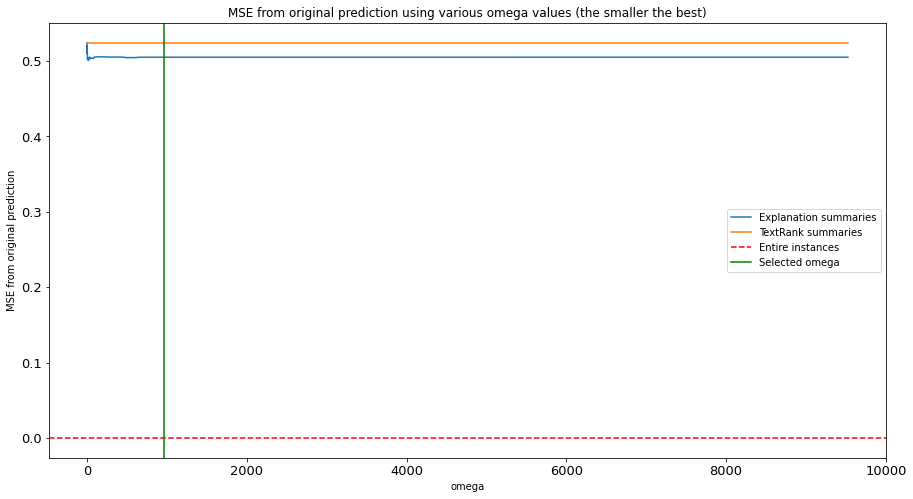

In [12]:
ax = pdf.plot(
    figsize=(15,8), 
    xlabel="omega", 
    ylabel="MSE from original prediction", 
    fontsize=13,
    title="MSE from original prediction using various omega values (the smaller the best)"
);

ax.axhline(y=0, color='r', linestyle='--', label='original instance');
# ax.axvline(x=last_change_fm, color='g', linestyle='--', label='last change in error, fm: ' + str(last_change_fm));
ax.axvline(x=962, color='g');
# plt.rcParams.update({'font.size': 13})
plt.legend(['Explanation summaries', 'TextRank summaries', 'Entire instances', 'Selected omega'])
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
# plt.savefig('omega_experiment_eniter.png')
plt.show()

In [13]:
chosen_fm=962

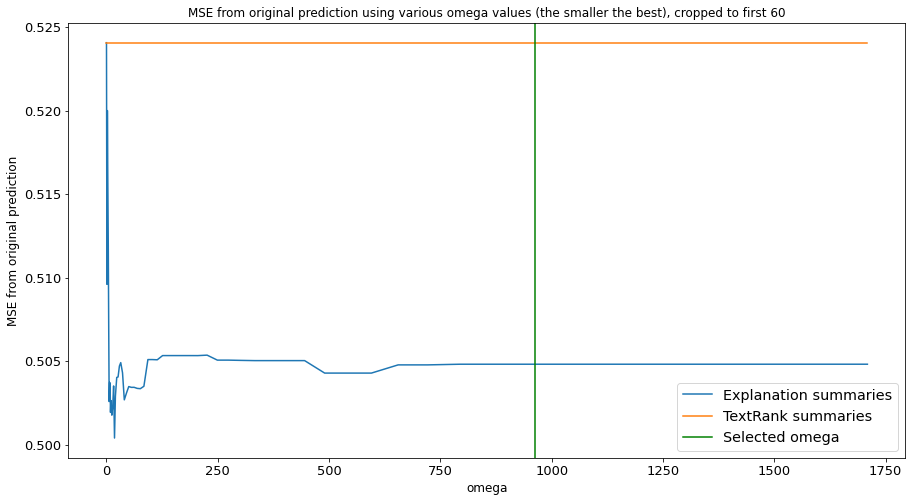

In [14]:
ax = pdf[:60].plot(
    figsize=(15,8), 
    xlabel="omega", 
    ylabel="MSE from original prediction", 
    fontsize=13, 
    title="MSE from original prediction using various omega values (the smaller the best), cropped to first 60"
);

# ax.axhline(y=0, color='r', linestyle='--', label='vline1.5custom');
# ax.axvline(x=last_change_fm, color='g', linestyle='--', label='last change in error, fm: ' + str(last_change_fm));
ax.axvline(x=962, color='g', label='choosen resulting fm');
plt.rcParams.update({'font.size': 12})
plt.legend()
# plt.savefig('omega_experiment.png')
plt.legend(['Explanation summaries', 'TextRank summaries', 'Selected omega'])
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

plt.show()

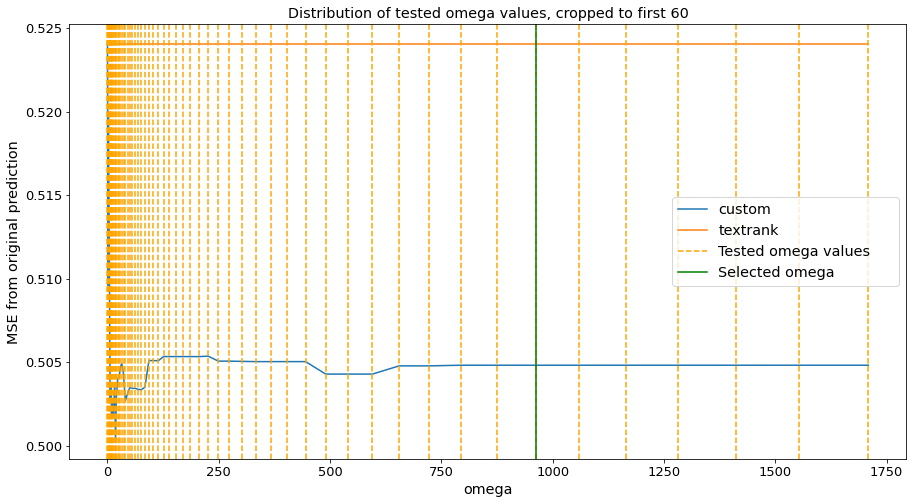

In [15]:
end = 60
ax = pdf[:end].plot(
    figsize=(15,8), 
    xlabel="omega", 
    ylabel="MSE from original prediction", 
    fontsize=13, 
    title="Distribution of tested omega values, cropped to first 60",
);

for i in range(end):
    l = ax.axvline(x=pdf.iloc[i].name, color='orange', linestyle='--');

ax.axvline(x=962, color='g', label='Selected omega');
l.set_label('Tested omega values     ')
plt.legend(['Explanation summaries', 'TextRank summaries'])

params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.legend()
# plt.savefig('omega_experiment_dist.png')
plt.show()

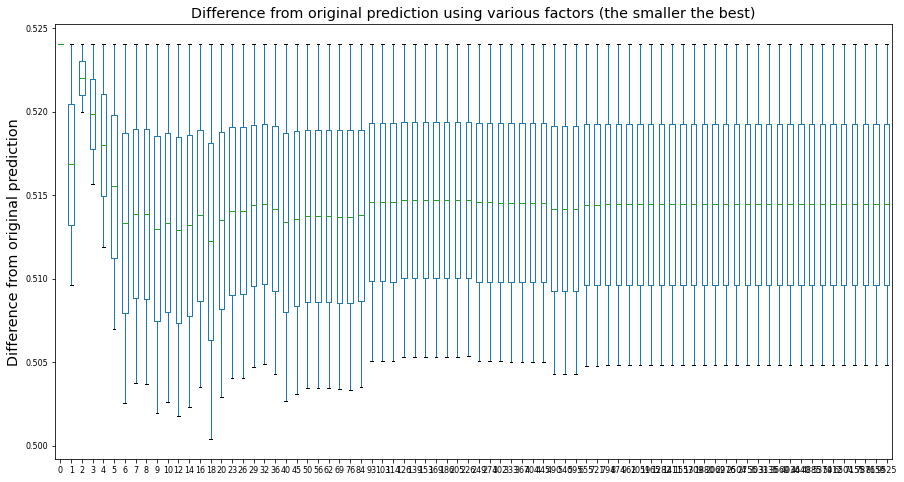

In [16]:
pdf.T.plot.box(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=8, 
    title="Difference from original prediction using various factors (the smaller the best)"
);

<AxesSubplot:>

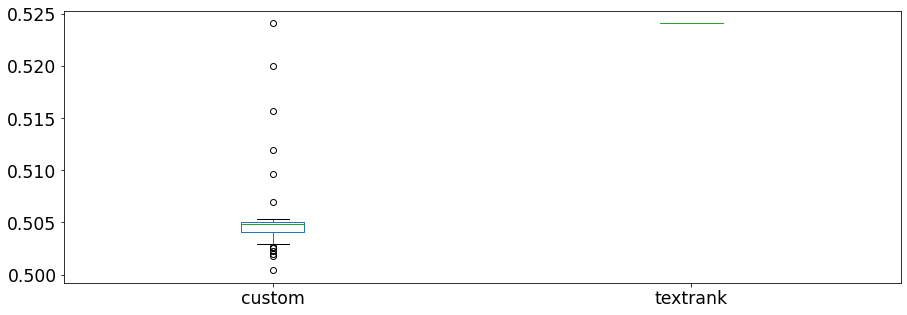

In [17]:
pdf.plot.box()

In [18]:
pdf.describe()

,custom,textrank
count,78.000000,7.800000e+01
mean,0.505153,5.240649e-01
std,0.003366,2.234818e-16
min,0.500390,5.240649e-01
25%,0.504107,5.240649e-01
50%,0.504811,5.240649e-01
75%,0.505026,5.240649e-01
max,0.524065,5.240649e-01


### Mean

In [19]:
pdfm = pd.DataFrame(processed_mean).T
pdfm = pdfm.rename({0:'custom', 1:'textrank'}, axis=1)
pdfm = pdfm.sort_index()
pdfm.tail()

,custom,textrank
6504,-0.018419,-0.009897
7155,-0.018419,-0.009897
7871,-0.018419,-0.009897
8659,-0.018419,-0.009897
9525,-0.018419,-0.009897


In [20]:
last_change_fm = pdfm.loc[np.isclose(pdfm.custom,pdfm.custom.unique()[-1])].index[0]

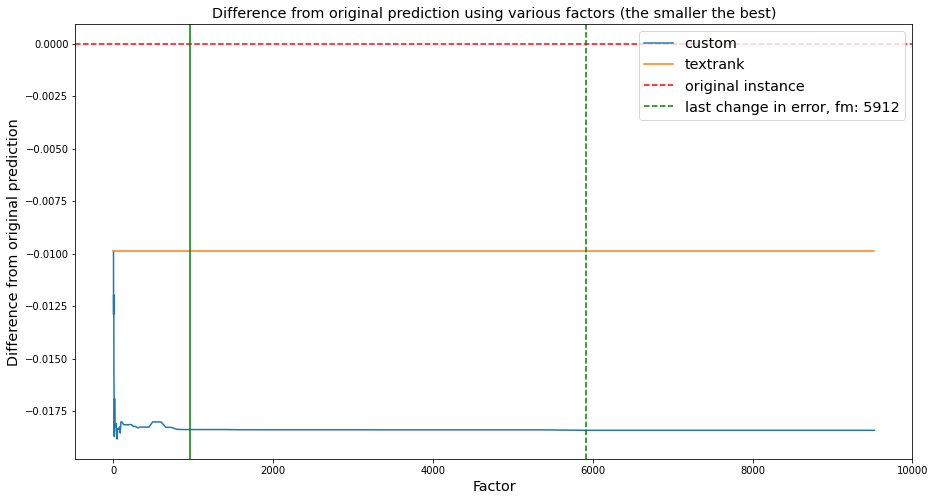

In [21]:
ax = pdfm.plot(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Difference from original prediction using various factors (the smaller the best)"
);

ax.axhline(y=0, color='r', linestyle='--', label='original instance');
ax.axvline(x=last_change_fm, color='g', linestyle='--', label='last change in error, fm: ' + str(last_change_fm));
ax.axvline(x=962, color='g');

plt.legend()
plt.show()

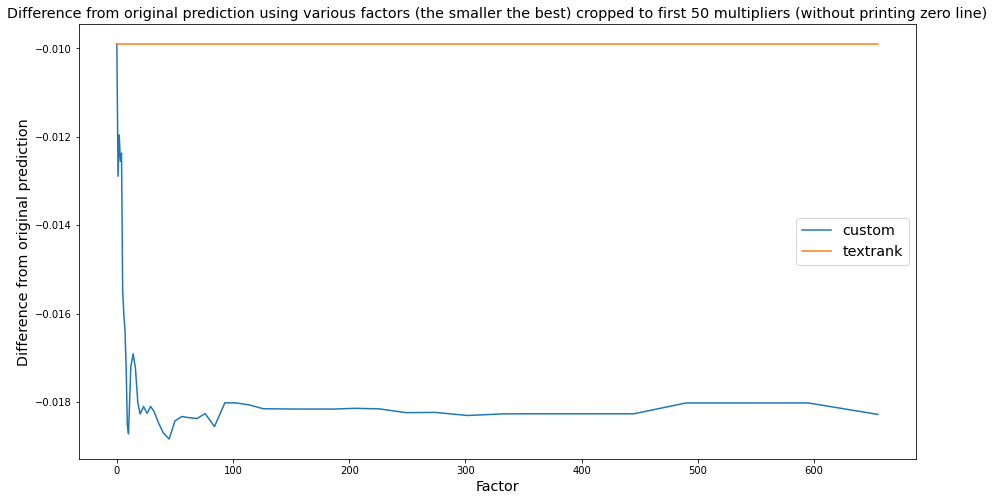

In [22]:
ax = pdfm[:50].plot(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Difference from original prediction using various factors (the smaller the best) cropped to first 50 multipliers (without printing zero line)"
);

# ax.axhline(y=0, color='r', linestyle='--', label='vline1.5custom');
# ax.axvline(x=last_change_fm, color='g', linestyle='--', label='last change in error, fm: ' + str(last_change_fm));

plt.legend()
plt.show()

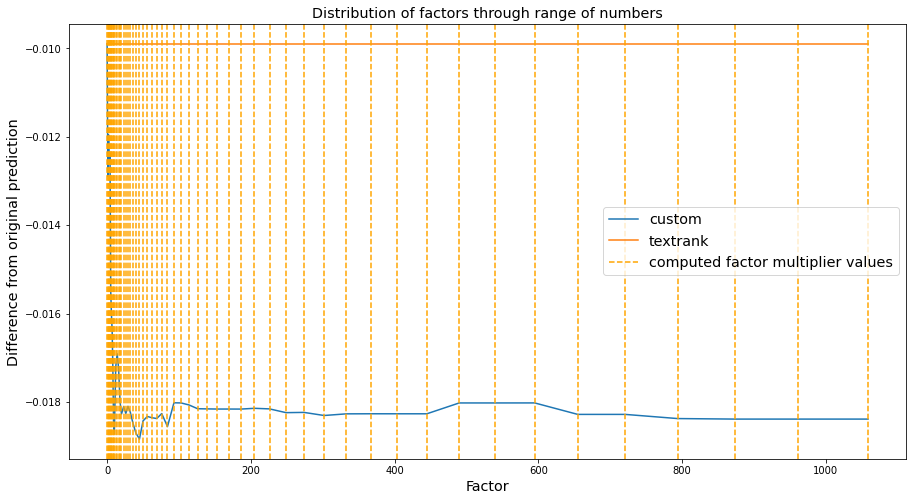

In [23]:
end = 55
ax = pdfm[:end].plot(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Distribution of factors through range of numbers"
);

for i in range(end):
    l = ax.axvline(x=pdfm.iloc[i].name, color='orange', linestyle='--');

l.set_label('computed factor multiplier values')
plt.legend()
plt.show()

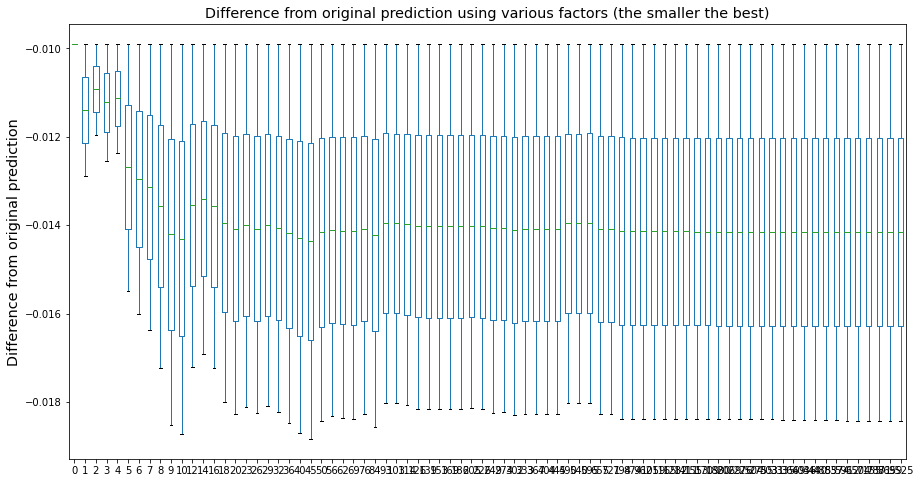

In [24]:
pdfm.T.plot.box(
    figsize=(15,8), 
    xlabel="Factor", 
    ylabel="Difference from original prediction", 
    fontsize=10, 
    title="Difference from original prediction using various factors (the smaller the best)"
);

<AxesSubplot:>

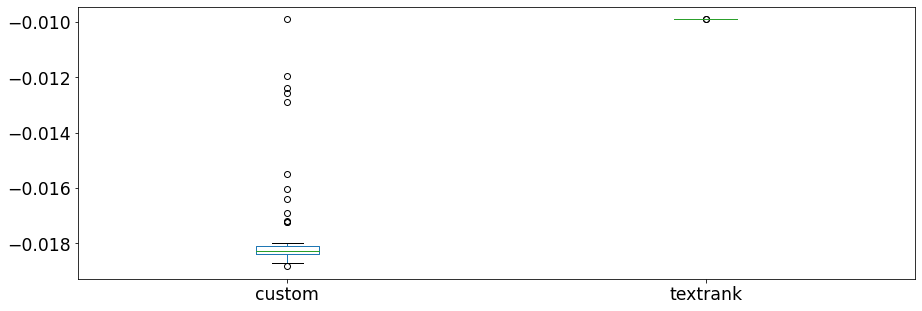

In [25]:
pdfm.plot.box()

In [26]:
pdfm.describe()

,custom,textrank
count,78.000000,7.800000e+01
mean,-0.017755,-9.897290e-03
std,0.001648,2.035344e-18
min,-0.018835,-9.897290e-03
25%,-0.018392,-9.897290e-03
50%,-0.018278,-9.897290e-03
75%,-0.018098,-9.897290e-03
max,-0.009897,-9.897290e-03


---
---
---

**Final factor: 962**